In [1]:
import numpy as np
import pandas as pd
import os
import math
from operator import truediv
import os
import random
import time
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.nn.modules.loss import _Loss
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
seed = 42

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(seed)


windowSize = 25
batch_size = 64

def padding(X, margin=2):
    newX = np.zeros((X.shape[0] + 2*margin, X.shape[1] + 2*margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX [x_offset : X.shape[0] + x_offset, y_offset : X.shape[1] + y_offset, :] = X
    return newX

def createPatch(X, y, windowSize=windowSize):
    margin = int((windowSize-1)/2)
    zeroPaddedX = padding(X, margin=margin)

    patchesData = np.zeros((X.shape[0]*X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0

    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin: r + margin + 1, c - margin:c + margin + 1]
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex += 1


    patchesData = patchesData[patchesLabels > 0, :, :, :]
    patchesLabels = patchesLabels[patchesLabels > 0]
    patchesLabels -= 1


    patchesData = patchesData.transpose((0, 3, 1, 2))

    return patchesData, patchesLabels


def applyPCA(X, numComponents=15):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX


def splitTrainTestSet(X, y, randomState=42):
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.7, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.40, random_state=42)
    return X_train, X_val, X_test, y_train, y_val, y_test



# Veri Ön İşleme

In [4]:
import h5py

In [5]:
houston18_file = h5py.File('/content/drive/MyDrive/proje/Houston18.mat', 'r')
houston18_gt_file = h5py.File('/content/drive/MyDrive/proje/Houston18_7gt.mat', 'r')

In [6]:
X = np.array(houston18_file['ori_data'])
y = np.array(houston18_gt_file['map'])

In [7]:

X = np.transpose(X, (1, 2, 0))

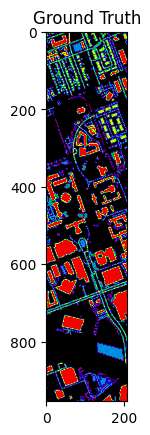

In [8]:
plt.imshow(y,cmap='nipy_spectral')

plt.title("Ground Truth")
plt.show()

In [9]:

X=applyPCA(X)

X,y=createPatch(X,y)

print(X.shape)
print(y.shape)

(53200, 15, 25, 25)
(53200,)


** Contrastive Loss için ön işleme**

In [ ]:
X_df = pd.DataFrame(X.reshape(X.shape[0], -1))
df = pd.DataFrame(X.reshape(X.shape[0], -1))
df['class'] = y.ravel()

y_df= df['class']
X_train_df,X_val_df,X_test_df,y_train_df,y_val_df,y_test_df=splitTrainTestSet(X_df,y_df)

print(X_train_df.shape)
print(X_val_df.shape)
print(X_test_df.shape)
print(y_train_df.shape)
print(y_val_df.shape)
print(y_test_df.shape)



columns = ['archor_img','postive_img','other_img','label','actual_label']
df_train_for_contrastive=pd.DataFrame(columns=columns)
df_test_for_contrastive=pd.DataFrame(columns=columns)
df_val_for_contrastive=pd.DataFrame(columns=columns)


val_df=pd.concat([X_val_df,y_val_df],axis=1)
train_df=pd.concat([X_train_df, y_train_df], axis=1)
test_df=pd.concat([X_test_df,y_test_df],axis=1)


train_df_reset_index= train_df.reset_index()
test_df_reset_index = test_df.reset_index()
val_df_reset_index = val_df.reset_index()

(15960, 9375)
(22344, 9375)
(14896, 9375)
(15960,)
(22344,)
(14896,)


In [ ]:
grouped = train_df_reset_index.groupby('class')['index'].apply(list).to_dict()

In [ ]:
for class_label, values in grouped.items():
      i = 0
      while i < len(values) - 1:
          anchor = values[i]
          other = values[i+1]
          label = 1.0
          new_row_dict = {'archor_img': anchor, 'postive_img': anchor, 'other_img': other, 'label': label,'actual_label':class_label}
          df_train_for_contrastive= df_train_for_contrastive._append(new_row_dict, ignore_index=True)
          i += 1


In [ ]:
df_train_for_contrastive

,archor_img,postive_img,other_img,label,actual_label
0,47773.0,47773.0,10283.0,1.0,1.0
1,34660.0,34660.0,30448.0,0.0,5.0
2,19465.0,19465.0,39930.0,0.0,6.0
3,14195.0,14195.0,9505.0,1.0,4.0
4,37997.0,37997.0,6571.0,0.0,5.0
...,...,...,...,...,...
31908,39200.0,39200.0,25027.0,1.0,5.0
31909,5741.0,5741.0,8433.0,0.0,6.0
31910,20358.0,20358.0,41576.0,1.0,5.0
31911,32230.0,32230.0,44463.0,1.0,5.0


In [ ]:
keys = list(grouped.keys())

for i, key in enumerate(keys):
    current_group = grouped[key]
    other_keys = [k for k in keys if k != key]
    for ind in current_group:

        random_key = random.choice(other_keys)
        other_group = grouped[random_key]
        other_ind = random.choice(other_group)
        label = 0.0
        new_row_dict = {'archor_img': ind, 'postive_img': ind, 'other_img': other_ind, 'label': label,'actual_label':key}
        df_train_for_contrastive= df_train_for_contrastive._append(new_row_dict, ignore_index=True)

In [ ]:
df_train_for_contrastive = df_train_for_contrastive.sample(frac=1).reset_index(drop=True)

In [ ]:
df_train_for_contrastive.to_csv('train_for_contrastive_Houston.csv')

In [ ]:
grouped = test_df_reset_index.groupby('class')['index'].apply(list).to_dict()

for class_label, values in grouped.items():
      i = 0
      while i < len(values) - 1:
          anchor = values[i]
          other = values[i+1]
          label = 1.0
          new_row_dict = {'archor_img': anchor, 'postive_img': anchor, 'other_img': other, 'label': label,'actual_label':class_label}
          df_test_for_contrastive= df_test_for_contrastive._append(new_row_dict, ignore_index=True)
          i += 1


In [ ]:
keys = list(grouped.keys())

for i, key in enumerate(keys):
    current_group = grouped[key]
    other_keys = [k for k in keys if k != key]
    for ind in current_group:

        random_key = random.choice(other_keys)
        other_group = grouped[random_key]
        other_ind = random.choice(other_group)
        label = 0.0
        new_row_dict = {'archor_img': ind, 'postive_img': ind, 'other_img': other_ind, 'label': label,'actual_label':key}
        df_test_for_contrastive= df_test_for_contrastive._append(new_row_dict, ignore_index=True)


df_test_for_contrastive = df_test_for_contrastive.sample(frac=1).reset_index(drop=True)

df_test_for_contrastive.to_csv('test_for_contrastive_Houston.csv')

In [ ]:
grouped = val_df_reset_index.groupby('class')['index'].apply(list).to_dict()

for class_label, values in grouped.items():
      i = 0
      while i < len(values) - 1:
          anchor = values[i]
          other = values[i+1]
          label = 1.0
          new_row_dict = {'archor_img': anchor, 'postive_img': anchor, 'other_img': other, 'label': label,'actual_label':class_label}
          df_val_for_contrastive= df_val_for_contrastive._append(new_row_dict, ignore_index=True)
          i += 1


In [ ]:
keys = list(grouped.keys())

for i, key in enumerate(keys):
    current_group = grouped[key]
    other_keys = [k for k in keys if k != key]
    for ind in current_group:

        random_key = random.choice(other_keys)
        other_group = grouped[random_key]
        other_ind = random.choice(other_group)
        label = 0.0
        new_row_dict = {'archor_img': ind, 'postive_img': ind, 'other_img': other_ind, 'label': label,'actual_label':key}
        df_val_for_contrastive= df_val_for_contrastive._append(new_row_dict, ignore_index=True)


df_val_for_contrastive = df_val_for_contrastive.sample(frac=1).reset_index(drop=True)

df_val_for_contrastive.to_csv('val_for_contrastive_Houston.csv')

In [ ]:
df_val_for_contrastive

,archor_img,postive_img,other_img,label,actual_label
0,46854.0,46854.0,32460.0,0.0,1.0
1,28973.0,28973.0,32011.0,1.0,5.0
2,25590.0,25590.0,35841.0,1.0,5.0
3,46275.0,46275.0,49296.0,0.0,1.0
4,13681.0,13681.0,4844.0,1.0,2.0
...,...,...,...,...,...
44676,43679.0,43679.0,14165.0,0.0,6.0
44677,21242.0,21242.0,26688.0,0.0,6.0
44678,15719.0,15719.0,37725.0,1.0,5.0
44679,19048.0,19048.0,10897.0,0.0,5.0


In [10]:
df_train_for_contrastive = pd.read_csv('/content/drive/MyDrive/dml/Houston-Contrastive/train_for_contrastive_Houston.csv',index_col=0)
df_test_for_contrastive = pd.read_csv('/content/drive/MyDrive/dml/Houston-Contrastive/test_for_contrastive_Houston.csv',index_col=0)
df_val_for_contrastive = pd.read_csv('/content/drive/MyDrive/dml/Houston-Contrastive/val_for_contrastive_Houston.csv',index_col=0)

indices_train = df_train_for_contrastive.iloc[:, 1].astype(int).values
indices_test = df_test_for_contrastive.iloc[:,1].astype(int).values
indices_val = df_val_for_contrastive.iloc[:,1].astype(int).values

X_Train = X[indices_train]
X_Val = X[indices_val]
X_Test = X[indices_test]
y_Train = y[indices_train]
y_Val = y[indices_val]
y_Test = y[indices_test]

In [11]:
class HSIDataset():

    def __init__(self, datafr,X_np):
        self.data = datafr
        self.X_np = X_np


        self.anchorimages = datafr.iloc[:, 0].values
        self.labels = datafr.iloc[:, 3].values
        self.actual_label = datafr.iloc[:, 4].values
        self.otherimages = datafr.iloc[:, 2].values
        self.index = datafr.index.values

    def __len__(self):
        return len(self.anchorimages)

    def __getitem__(self, item):


        anchor_image_index = self.anchorimages[item]
        anchor_image_index=int(anchor_image_index)
        anchor_img = self.X_np[anchor_image_index]


        label = self.labels[item]

        actual_label = self.actual_label[item]

        other_image_index = self.otherimages[item]
        other_image_index=int(other_image_index)
        other_img = self.X_np[other_image_index]

        anchor_img_tensor = torch.tensor(anchor_img)
        other_img_tensor = torch.tensor(other_img)
        label_tensor = torch.tensor(label)
        actual_label_tensor = torch.tensor(actual_label)

        anchor_img_tensor=anchor_img_tensor.float()
        other_img_tensor=other_img_tensor.float()
        label_tensor=label_tensor.float()
        actual_label_tensor=actual_label_tensor.float()

        return anchor_img_tensor,other_img_tensor, label_tensor,actual_label_tensor,anchor_image_index

In [12]:
def get_train_dataset():
    train_dataset = HSIDataset(df_train_for_contrastive,X)
    return train_dataset

def get_test_dataset():
    test_dataset = HSIDataset(df_test_for_contrastive,X)
    return test_dataset

def get_val_dataset():
    val_dataset = HSIDataset(df_val_for_contrastive,X)
    return val_dataset


from torch.utils.data import DataLoader

train_dataset=get_train_dataset()


train_dl = DataLoader(train_dataset,batch_size=64,shuffle=True,num_workers=4,pin_memory=True)

val_dataset = get_val_dataset()

val_dl = DataLoader(val_dataset,batch_size=64,shuffle=True,num_workers=4,pin_memory=True)

test_dataset = get_test_dataset()

test_dl = DataLoader(test_dataset,batch_size=64,shuffle=True,num_workers=4,pin_memory=True)


# Network ve Loss fonksiyonu

In [13]:
def l2_norm(x, y):
    return ((x - y) ** 2).sum(1)

In [14]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0, metric=l2_norm, reduction='mean'):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        self.metric = metric
        if reduction == 'mean':
            self.reduction = torch.mean
        elif reduction == 'sum':
            self.reduction = torch.sum

    @staticmethod
    def normalize_x(x):
        z = torch.sqrt(torch.sum(x ** 2, dim=1, keepdim=True))
        return x / z

    def forward(self, x_p, x_q, y, normalize=True):
        if normalize:
            x_p = self.normalize_x(x_p)
            x_q = self.normalize_x(x_q)
        distance = self.metric(x_p, x_q)

        loss = y * distance + (1 - y) * F.relu(self.margin - distance)
        loss = self.reduction(loss)

        return loss

In [15]:
class CNNetwork(nn.Module):
    def __init__(self):
        super(CNNetwork, self).__init__()

        self.conv1 = nn.Conv2d(15, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU(inplace=True)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU(inplace=True)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc4 = nn.Linear(128 * 3 * 3, 512)
        self.relu4 = nn.ReLU(inplace=True)
        self.fc5 = nn.Linear(512, 128)


    def forward(self, x):

        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        x = self.conv3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)

        x = x.view(x.size(0), -1)
        x = self.fc4(x)
        x = self.relu4(x)
        x = self.fc5(x)


        return x



class ClassificationNN(nn.Module):
    def __init__(self):
        super(ClassificationNN, self).__init__()
        self.fc8 = nn.Linear(128,64)
        self.fc6 = nn.Linear(64, 32)
        self.relu = nn.ReLU(inplace=True)
        self.fc7 = nn.Linear(32, 7)

    def forward(self, x):

        x = self.fc8(x)
        x = self.relu(x)
        x = self.fc6(x)
        x = self.relu(x)
        x = self.fc7(x)


        return x






# Network ve Train

In [16]:
def evaluate(model, val_dl, loss_fn, device):
    model.eval()
    with torch.no_grad():
        running_loss = []
        running_acc = []


        for step, (anchor_img, other_img,label,_,_) in enumerate(tqdm(val_dl, desc="Evaluating", leave=False)):
            anchor_img = anchor_img.to(device)
            other_img = other_img.to(device)
            label = label.to(device)

            anchor_output = model(anchor_img)
            other_output = model(other_img)


            loss = loss_fn(anchor_output, other_output,label)




            running_loss.append(loss.item())



        avg_loss = sum(running_loss) / len(running_loss)


    return avg_loss


def train(model, train_dl, val_dl, loss_fn, optimizer, device):


    train_loss = []
    val_loss = []

    model.train()
    best_val_acc = 0.0
    for epoch in tqdm(range(20), desc="Epochs"):
        running_loss = []

        for step, (anchor_img,other_img,label,_,_) in enumerate(tqdm(train_dl, desc="Training", leave=False)):
            anchor_img = anchor_img.to(device)
            other_img = other_img.to(device)
            label = label.to(device)

            anchor_output = model(anchor_img)
            other_output = model(other_img)



            loss = loss_fn(anchor_output,other_output,label)

            running_loss.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


        avg_loss = sum(running_loss) / len(running_loss)



        train_loss.append(avg_loss)



        eval_loss = evaluate(model, val_dl, loss_fn, device)


        val_loss.append(eval_loss)


        print(f"Epoch {epoch+1}/{20} - Training loss: {avg_loss:.4f}, Validation loss: {eval_loss:.4f}")




    return train_loss, val_loss

In [17]:
device = torch.device("cuda")
model = CNNetwork().to(device)
Optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = ContrastiveLoss()

In [18]:
from tqdm import tqdm

In [19]:
train_loss, val_los = train(model, train_dl, val_dl, loss_fn, Optimizer, device)

Training:  99%|█████████▊| 492/499 [00:05<00:00, 124.12it/s]
                                                            
Epochs:   5%|▌         | 1/20 [00:10<03:16, 10.33s/it]

Epoch 1/20 - Training loss: 0.1247, Validation loss: 0.0696



Training: 100%|█████████▉| 498/499 [00:04<00:00, 131.09it/s]
                                                            
Epochs:  10%|█         | 2/20 [00:19<02:48,  9.37s/it]

Epoch 2/20 - Training loss: 0.0479, Validation loss: 0.0473



Training: 100%|██████████| 499/499 [00:04<00:00, 123.78it/s]
                                                            
Epochs:  15%|█▌        | 3/20 [00:28<02:36,  9.21s/it]

Epoch 3/20 - Training loss: 0.0348, Validation loss: 0.0406



Training:  99%|█████████▊| 492/499 [00:04<00:00, 118.28it/s]
                                                            
Epochs:  20%|██        | 4/20 [00:37<02:29,  9.35s/it]

Epoch 4/20 - Training loss: 0.0311, Validation loss: 0.0383



Training:  97%|█████████▋| 485/499 [00:04<00:00, 127.22it/s]
                                                            
Epochs:  25%|██▌       | 5/20 [00:46<02:18,  9.23s/it]

Epoch 5/20 - Training loss: 0.0302, Validation loss: 0.0377



Training:  99%|█████████▉| 493/499 [00:04<00:00, 118.70it/s]
                                                            
Epochs:  30%|███       | 6/20 [00:55<02:08,  9.21s/it]

Epoch 6/20 - Training loss: 0.0266, Validation loss: 0.0343



Training:  98%|█████████▊| 489/499 [00:04<00:00, 131.41it/s]
                                                            
Epochs:  35%|███▌      | 7/20 [01:04<01:57,  9.04s/it]

Epoch 7/20 - Training loss: 0.0261, Validation loss: 0.0361



Training:  99%|█████████▉| 493/499 [00:04<00:00, 119.26it/s]
                                                            
Epochs:  40%|████      | 8/20 [01:13<01:48,  9.05s/it]

Epoch 8/20 - Training loss: 0.0265, Validation loss: 0.0371



Training: 100%|█████████▉| 497/499 [00:04<00:00, 121.09it/s]
                                                            
Epochs:  45%|████▌     | 9/20 [01:22<01:39,  9.02s/it]

Epoch 9/20 - Training loss: 0.0263, Validation loss: 0.0352



Training:  97%|█████████▋| 486/499 [00:04<00:00, 124.13it/s]
                                                            
Epochs:  50%|█████     | 10/20 [01:31<01:29,  8.92s/it]

Epoch 10/20 - Training loss: 0.0259, Validation loss: 0.0358



Training:  98%|█████████▊| 488/499 [00:04<00:00, 122.79it/s]
                                                            
Epochs:  55%|█████▌    | 11/20 [01:40<01:20,  8.96s/it]

Epoch 11/20 - Training loss: 0.0289, Validation loss: 0.0347



Training:  97%|█████████▋| 486/499 [00:04<00:00, 128.40it/s]
                                                            
Epochs:  60%|██████    | 12/20 [01:49<01:11,  8.98s/it]

Epoch 12/20 - Training loss: 0.0254, Validation loss: 0.0340



Training: 100%|█████████▉| 497/499 [00:04<00:00, 126.74it/s]
                                                            
Epochs:  65%|██████▌   | 13/20 [01:58<01:02,  8.91s/it]

Epoch 13/20 - Training loss: 0.0247, Validation loss: 0.0357



Training:  98%|█████████▊| 490/499 [00:04<00:00, 112.31it/s]
                                                            
Epochs:  70%|███████   | 14/20 [02:07<00:54,  9.01s/it]

Epoch 14/20 - Training loss: 0.0257, Validation loss: 0.0360



Training: 100%|█████████▉| 498/499 [00:04<00:00, 131.64it/s]
                                                            
Epochs:  75%|███████▌  | 15/20 [02:16<00:45,  9.04s/it]

Epoch 15/20 - Training loss: 0.0257, Validation loss: 0.0375



Training:  97%|█████████▋| 486/499 [00:04<00:00, 126.64it/s]
                                                            
Epochs:  80%|████████  | 16/20 [02:25<00:35,  8.94s/it]

Epoch 16/20 - Training loss: 0.0252, Validation loss: 0.0334



Training: 100%|█████████▉| 497/499 [00:04<00:00, 122.41it/s]
                                                            
Epochs:  85%|████████▌ | 17/20 [02:33<00:26,  8.92s/it]

Epoch 17/20 - Training loss: 0.0247, Validation loss: 0.0322



Training: 100%|█████████▉| 498/499 [00:04<00:00, 123.83it/s]
                                                            
Epochs:  90%|█████████ | 18/20 [02:43<00:17,  8.99s/it]

Epoch 18/20 - Training loss: 0.0248, Validation loss: 0.0392



Training:  99%|█████████▉| 495/499 [00:04<00:00, 128.31it/s]
                                                            
Epochs:  95%|█████████▌| 19/20 [02:51<00:08,  8.93s/it]

Epoch 19/20 - Training loss: 0.0255, Validation loss: 0.0349



Training:  98%|█████████▊| 488/499 [00:04<00:00, 114.75it/s]
                                                            
Epochs: 100%|██████████| 20/20 [03:00<00:00,  9.04s/it]

Epoch 20/20 - Training loss: 0.0242, Validation loss: 0.0329


In [21]:
torch.save(model.state_dict(), 'houston_contrastive_model.pth')

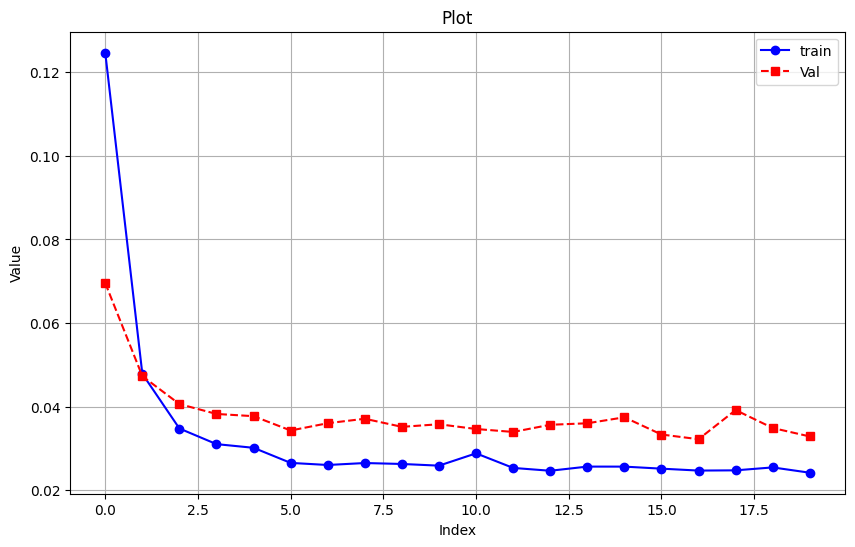

In [20]:
indices =list(range(len(train_loss)))

plt.figure(figsize=(10, 6))
plt.plot(indices, train_loss, marker='o', linestyle='-', color='b', label='train')
plt.plot(indices, val_los, marker='s', linestyle='--', color='r', label='Val')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Plot')
plt.legend()
plt.grid(True)
plt.show()

# 1. Network Sonrası Elde edilen değerleri Sınıflandırma Networkü için Ön işleme

In [22]:
class FeatureDataset():
    def __init__(self, feature, feature_labels):
        self.data = feature
        self.labels = feature_labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]


In [23]:
model.eval()
val_features = []
val_labels = []
seen_anchors = set()

with torch.no_grad():
    for anchor_img, _, _, anchor_label,anchor_index in val_dl:
        size_b = anchor_img.size(0)
        for i in range(size_b):
            if anchor_index[i].item() not in seen_anchors:
                seen_anchors.add(anchor_index[i].item())
                img = anchor_img[i].unsqueeze(0).to(device)
                features = model(img)
                val_features.append(features)
                val_labels.append(anchor_label[i])

val_features = torch.cat(val_features, dim=0)

val_labels = [label.unsqueeze(0) for label in val_labels]
val_labels = torch.cat(val_labels, dim=0)

dataset_train = FeatureDataset(val_features, val_labels)

Feature_train_loader = DataLoader(dataset_train, batch_size=64, shuffle=True)

In [24]:
model.eval()
test_features = []
test_labels = []
seen_anchors = set()

with torch.no_grad():
    for anchor_img, _, _, anchor_label,anchor_index in test_dl:
        size_b = anchor_img.size(0)
        for i in range(size_b):
            if anchor_index[i] not in seen_anchors:
                seen_anchors.add(anchor_index[i])
                img = anchor_img[i].unsqueeze(0).to(device)
                features = model(img)
                test_features.append(features)
                test_labels.append(anchor_label[i])

test_features = torch.cat(test_features, dim=0)
test_labels = [label.unsqueeze(0) for label in test_labels]
test_labels = torch.cat(test_labels, dim=0)

dataset_test = FeatureDataset(test_features, test_labels)

Feature_test_loader = DataLoader(dataset_test, batch_size=64, shuffle=True)

# Sınıflandırma için ön işleme

In [25]:
classificationModel = ClassificationNN()
optimizer_feature = optim.Adam(classificationModel.parameters(), lr=0.001)
loss_for_classification = nn.CrossEntropyLoss()


In [26]:
def evaluate_classification(model, test_class_dl, clas_loss_fn, device):
    model.eval()

    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in test_class_dl:
            targets= targets.type(torch.LongTensor)
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = clas_loss_fn(outputs, targets)
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    average_loss = total_loss / len(test_class_dl)
    accuracy = (correct / total) * 100

    return average_loss, accuracy




In [27]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score

def train_classification(model_classification, feat_train_loader, feat_criterion, feat_optimizer, device, test_class_dl):
    model_classification.to(device)
    model_classification.train()

    loss_list = []
    epoch_accuracies = []
    evaluation_losses = []
    evaluation_accuracies = []

    for epoch in tqdm(range(20), desc="Epochs"):
        model_classification.train()
        all_labels = []
        all_predictions = []
        epoch_loss_list = []

        for inputs, labels in feat_train_loader:
            labels = labels.type(torch.LongTensor)
            inputs, labels = inputs.to(device), labels.to(device)

            feat_optimizer.zero_grad()
            outputs = model_classification(inputs)
            loss = feat_criterion(outputs, labels)
            loss.backward()
            feat_optimizer.step()

            epoch_loss_list.append(loss.item())
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

        accuracy = accuracy_score(all_labels, all_predictions)
        epoch_accuracies.append(accuracy)
        loss_list.extend(epoch_loss_list)

        eval_loss, eval_accuracy = evaluate_classification(model_classification, test_class_dl, feat_criterion, device)
        evaluation_losses.append(eval_loss)
        evaluation_accuracies.append(eval_accuracy)

        print(f"Epoch {epoch+1}/{20}, Training Loss: {sum(epoch_loss_list)/len(epoch_loss_list):.4f}, Training Accuracy: {accuracy:.4f}")
        print(f"Validation Loss: {eval_loss:.4f}, Validation Accuracy: {eval_accuracy:.2f}%")

    return loss_list, epoch_accuracies, evaluation_losses, evaluation_accuracies


In [28]:
for param in classificationModel.parameters():
    param.requires_grad = True

In [29]:
loss_list, epoch_accuracies, evaluation_losses, evaluation_accuracies = train_classification(classificationModel,Feature_train_loader,loss_for_classification,optimizer_feature,device,Feature_test_loader)

Epochs:   5%|▌         | 1/20 [00:01<00:26,  1.42s/it]

Epoch 1/20, Training Loss: 0.2898, Training Accuracy: 0.8988
Validation Loss: 0.2045, Validation Accuracy: 91.99%


Epochs:  10%|█         | 2/20 [00:02<00:23,  1.30s/it]

Epoch 2/20, Training Loss: 0.2112, Training Accuracy: 0.9136
Validation Loss: 0.2057, Validation Accuracy: 92.09%


Epochs:  15%|█▌        | 3/20 [00:03<00:21,  1.25s/it]

Epoch 3/20, Training Loss: 0.2044, Training Accuracy: 0.9153
Validation Loss: 0.2137, Validation Accuracy: 88.24%


Epochs:  20%|██        | 4/20 [00:05<00:19,  1.23s/it]

Epoch 4/20, Training Loss: 0.2036, Training Accuracy: 0.9161
Validation Loss: 0.1975, Validation Accuracy: 91.98%


Epochs:  25%|██▌       | 5/20 [00:06<00:18,  1.22s/it]

Epoch 5/20, Training Loss: 0.2013, Training Accuracy: 0.9173
Validation Loss: 0.1971, Validation Accuracy: 91.97%


Epochs:  30%|███       | 6/20 [00:07<00:16,  1.21s/it]

Epoch 6/20, Training Loss: 0.1997, Training Accuracy: 0.9168
Validation Loss: 0.1938, Validation Accuracy: 91.95%


Epochs:  35%|███▌      | 7/20 [00:08<00:15,  1.21s/it]

Epoch 7/20, Training Loss: 0.1984, Training Accuracy: 0.9169
Validation Loss: 0.1948, Validation Accuracy: 91.98%


Epochs:  40%|████      | 8/20 [00:09<00:14,  1.20s/it]

Epoch 8/20, Training Loss: 0.1970, Training Accuracy: 0.9172
Validation Loss: 0.1943, Validation Accuracy: 91.97%


Epochs:  45%|████▌     | 9/20 [00:10<00:13,  1.19s/it]

Epoch 9/20, Training Loss: 0.1976, Training Accuracy: 0.9165
Validation Loss: 0.1953, Validation Accuracy: 91.97%


Epochs:  50%|█████     | 10/20 [00:12<00:11,  1.18s/it]

Epoch 10/20, Training Loss: 0.1964, Training Accuracy: 0.9165
Validation Loss: 0.1973, Validation Accuracy: 91.97%


Epochs:  55%|█████▌    | 11/20 [00:13<00:10,  1.18s/it]

Epoch 11/20, Training Loss: 0.1949, Training Accuracy: 0.9166
Validation Loss: 0.1953, Validation Accuracy: 91.91%


Epochs:  60%|██████    | 12/20 [00:14<00:09,  1.18s/it]

Epoch 12/20, Training Loss: 0.1957, Training Accuracy: 0.9168
Validation Loss: 0.1932, Validation Accuracy: 91.94%


Epochs:  65%|██████▌   | 13/20 [00:15<00:08,  1.19s/it]

Epoch 13/20, Training Loss: 0.1941, Training Accuracy: 0.9164
Validation Loss: 0.1914, Validation Accuracy: 91.97%


Epochs:  70%|███████   | 14/20 [00:16<00:07,  1.20s/it]

Epoch 14/20, Training Loss: 0.1944, Training Accuracy: 0.9168
Validation Loss: 0.1919, Validation Accuracy: 91.98%


Epochs:  75%|███████▌  | 15/20 [00:18<00:05,  1.19s/it]

Epoch 15/20, Training Loss: 0.1937, Training Accuracy: 0.9168
Validation Loss: 0.1933, Validation Accuracy: 91.87%


Epochs:  80%|████████  | 16/20 [00:19<00:04,  1.20s/it]

Epoch 16/20, Training Loss: 0.1933, Training Accuracy: 0.9171
Validation Loss: 0.1894, Validation Accuracy: 91.95%


Epochs:  85%|████████▌ | 17/20 [00:20<00:03,  1.20s/it]

Epoch 17/20, Training Loss: 0.1934, Training Accuracy: 0.9164
Validation Loss: 0.1892, Validation Accuracy: 91.96%


Epochs:  90%|█████████ | 18/20 [00:21<00:02,  1.21s/it]

Epoch 18/20, Training Loss: 0.1940, Training Accuracy: 0.9162
Validation Loss: 0.1901, Validation Accuracy: 91.99%


Epochs:  95%|█████████▌| 19/20 [00:22<00:01,  1.20s/it]

Epoch 19/20, Training Loss: 0.1922, Training Accuracy: 0.9163
Validation Loss: 0.1899, Validation Accuracy: 91.93%


Epochs: 100%|██████████| 20/20 [00:24<00:00,  1.21s/it]

Epoch 20/20, Training Loss: 0.1921, Training Accuracy: 0.9170
Validation Loss: 0.1876, Validation Accuracy: 91.99%


In [30]:
torch.save(classificationModel.state_dict(), 'houston_classification_contrastive_model.pth')

# Değerlendirme

In [31]:
X_tensor = torch.tensor(X)
X_tensor=X_tensor.float()
X_tensor = X_tensor.to(device)

In [32]:
y_pred_array = []
i=0
while i <  X_tensor.shape[0]:
      a =  X_tensor[i]
      a = a.unsqueeze(0)

      output=model(a)
      clas_tahmin = classificationModel(output)
      clas_tahmin =clas_tahmin.argmax().float()
      clas_tahmin=clas_tahmin.item()
      y_pred_array.append(clas_tahmin)
      i+=1


In [33]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score, f1_score

In [34]:
s=accuracy_score(y,y_pred_array)
c=cohen_kappa_score(y,y_pred_array)
f1=f1_score(y,y_pred_array,average='weighted')
print(s,c,f1)

0.9200187969924812 0.8634798121986017 0.8876439008973871


In [35]:
gt_2=np.array(houston18_gt_file['map'])
gt_2=gt_2.reshape(-1)
a=gt_2.shape[0]
gt_3=np.array(houston18_gt_file['map'])

In [36]:

d=0
i=0
for i in range(a):
    if gt_2[i] != 0:
              gt_2[i]=(y_pred_array[d] + 1)
              d += 1

gt_2=gt_2.reshape(954,-1)

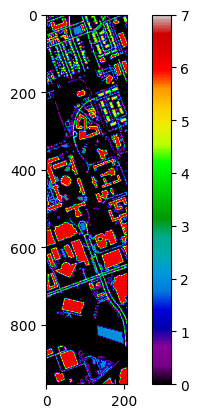

In [37]:
plt.imshow(gt_3,cmap='nipy_spectral')
plt.colorbar()

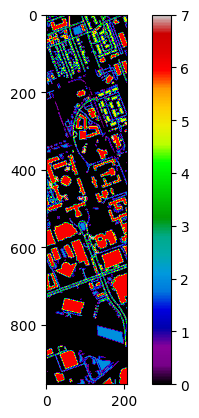

In [38]:
plt.imshow(gt_2,cmap='nipy_spectral')
plt.colorbar()